# Screen Parsing with OmniParser and OpenVINO

Recent breakthrough in Visual Language Processing and Large Language models made significant strides in understanding and interacting with the world through text and images. However, accurately parsing and understanding complex graphical user interfaces (GUIs) remains a significant challenge.
OmniParser is a comprehensive method for parsing user interface screenshots into structured and easy-to-understand elements. This enables more accurate and efficient interaction with GUIs, empowering AI agents to perform tasks across various platforms and applications.

![](https://microsoft.github.io/OmniParser/static/images/flow_merged0.png)


More details about model can be found in [Microsoft blog post](https://www.microsoft.com/en-us/research/articles/omniparser-for-pure-vision-based-gui-agent/), [paper](https://arxiv.org/pdf/2408.00203), [original repo](https://github.com/microsoft/OmniParser) and [model card](https://huggingface.co/microsoft/OmniParser).
In this tutorial we consider how to run OmniParser using OpenVINO.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare models](#Prepare-models)
    - [Convert models to OpenVINO Intermediate representation format](#Convert-models-to-OpenVINO-Intermediate-representation-format)
        - [Icon Detector](#Icon-Detector)
        - [Screen captioning model](#Screen-captioning-model)
- [Run OmniParser using OpenVINO](#Run-OmniParser-using-OpenVINO)
  - [Icon Detector](#Icon-Detector)
      - [Select inference device for icon detector](#Select-inference-device-for-icon-detector)
  - [Screen regions captioning](#Screen-regions-captioning)
      - [Select device for screen region captioning](#Select-device-for-screen-region-captioning)
  - [Recognition text on the screen](#Recognition-text-on-the-screen)
      - [Select device for OCR](#Select-device-for-OCR)
  - [Run model inference](#Run-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/omniparser/omniparser.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from pathlib import Path
import requests

notebook_utils_path = Path("notebook_utils.py")
florence_helper_path = Path("ov_florence2_helper.py")
omniparser_helper_path = Path("ov_omniparser_helper.py")
pip_utils_path = Path("pip_helper.py")

if not notebook_utils_path.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    notebook_utils_path.open("w", encoding="utf-8").write(r.text)

if not pip_utils_path.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/pip_helper.py",
    )
    pip_utils_path.open("w", encoding="utf-8").write(r.text)

if not florence_helper_path.exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/florence2/ov_florence2_helper.py")
    florence_helper_path.open("w", encoding="utf-8").write(r.text)

if not omniparser_helper_path.exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/omniparser/ov_omniparser_helper.py")
    omniparser_helper_path.open("w", encoding="utf-8").write(r.text)

In [ ]:
import platform
from pip_helper import pip_install

pip_install(
    "torch>=2.1",
    "torchvision",
    "accelerate",
    "supervision==0.18.0",
    "transformers>=4.45",
    "timm",
    "einops==0.8.0",
    "ultralytics==8.3.59",
    "pillow",
    "opencv-python",
    "gradio>=4.19",
    "--extra-index-url",
    "https://download.pytorch.org/whl/cpu",
)
pip_install("easyocr", "--extra-index-url", "https://download.pytorch.org/whl/cpu")
pip_install("openvino>=2024.4.0")

if platform.system() == "Darwin":
    pip_install("numpy<2.0")

## Prepare models
[back to top ⬆️](#Table-of-contents:)

OmniParser leverages a two-step process:
1. Interactable Region Detection:
   -  Identifies clickable elements like buttons and icons within a UI.
   -  Employs a specialized model trained on a diverse dataset of web pages.
   -  Accurately detects interactive elements, even in complex UIs.

2. Semantic Captioning:
   - Assigns meaningful descriptions to detected elements.
   - Combines optical character recognition (OCR) and a captioning model.
   - Provides context for accurate action generation.

### Convert models to OpenVINO Intermediate representation format
[back to top ⬆️](#Table-of-contents:)
For starting work with OpenVINO we should convert models to OpenVINO Intermediate Representation format first.

[OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

Let's consider each pipeline part.

#### Icon Detector
[back to top ⬆️](#Table-of-contents:)

Icon detector in OmniParser is represented by YOLO based model trained on curated by model authors interactable icon detection dataset.

For conversion and model inference we will utilize Ultralytics provided API. You can find more examples of this API usage in these [tutorials](https://openvinotoolkit.github.io/openvino_notebooks/?libraries=Ultralytics)

In [3]:
from ov_omniparser_helper import download_omniparser_icon_detector

icon_detector_dir = download_omniparser_icon_detector()

2024-11-18 10:07:51.252501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 10:07:51.266051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731910071.284414 4138051 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731910071.288979 4138051 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:07:51.305032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

'weights/icon_detect/best.pt' already exists.
'weights/icon_detect/model.yaml' already exists.


In [4]:
from ultralytics import YOLO
import gc

ov_icon_detector_path = icon_detector_dir / "best_openvino_model/best.xml"

if not ov_icon_detector_path.exists():
    icon_detector = YOLO(icon_detector_dir / "best.pt", task="detect")
    icon_detector.export(format="openvino", dynamic=True, half=True)
    del icon_detector
    gc.collect();

#### Screen captioning model
[back to top ⬆️](#Table-of-contents:)

The second part of OmniParser pipeline is creating detailed descriptions of recognized clickable regions. For these purposes pipeline suggests to use several visual language processing models like BLIP2, Florence2 or Phi-3-Vision. In this tutorial we will focus on making screen region captioning using Florence2. Previously we explained in details model workflow and steps for running it using OpenVINO in this [tutorial](https://openvinotoolkit.github.io/openvino_notebooks/?search=Florence-2%3A+Open+Source+Vision+Foundation+Model). 

In [5]:
from ov_omniparser_helper import download_omniparser_florence_model

florence_caption_dir = download_omniparser_florence_model()

In [6]:
from ov_florence2_helper import convert_florence2

# Uncomment the line to see conversion code
# ??convert_florence2

In [7]:
ov_florence_path = Path("weights/icon_caption_florence_ov")
convert_florence2(florence_caption_dir.name, ov_florence_path, florence_caption_dir)

✅ icon_caption_florence already converted and can be found in weights/icon_caption_florence_ov


## Run OmniParser using OpenVINO
[back to top ⬆️](#Table-of-contents:)

Now, it is time to configure and run OmniParser inference using OpenVINO.

### Icon Detector
[back to top ⬆️](#Table-of-contents:)

#### Select inference device for icon detector
[back to top ⬆️](#Table-of-contents:)

In [8]:
from notebook_utils import device_widget

device = device_widget("CPU", ["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [9]:
from ov_omniparser_helper import load_ov_icon_detector

ov_icon_detector = load_ov_icon_detector(ov_icon_detector_path, device.value)

Ultralytics YOLOv8.1.24 🚀 Python-3.11.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-10980XE 3.00GHz)
Loading weights/icon_detect/best_openvino_model for OpenVINO inference...


### Screen regions captioning
[back to top ⬆️](#Table-of-contents:)

`OVFlorence2Model` class defined in `ov_florence2_helper.py` provides convenient way for running model. It accepts directory with converted model and inference device as arguments. For running model we will use `generate` method. Additionally, for model usage we also need `Processor` class, that distributed with original model and can be loaded using `AutoProcessor` from `transformers` library. Processor is responsible for input data preparation and decoding model output.

In [10]:
from ov_florence2_helper import OVFlorence2Model
from transformers import AutoProcessor

# Uncomment the line to see model class code
# ??OVFlorence2Model

#### Select device for screen region captioning
[back to top ⬆️](#Table-of-contents:)

In [11]:
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [12]:
ov_icon_caption_gen = OVFlorence2Model(ov_florence_path, device.value)
processor = AutoProcessor.from_pretrained(ov_florence_path, trust_remote_code=True)

### Recognition text on the screen
[back to top ⬆️](#Table-of-contents:)

Alongside with captioning model, OmniParser also uses Optical Character Recognition (OCR) for understanding text on the screen. [EasyOCR](https://github.com/JaidedAI/EasyOCR) is a python module for extracting text from image. It is a general OCR that can read both natural scene text and dense text in document and supports 80+ languages. EasyOCR utilizes AI for detection text regions and recognize text inside of predicted regions. We will also utilize both text detection and recognition models using OpenVINO.

#### Select device for OCR
[back to top ⬆️](#Table-of-contents:)

In [13]:
import ipywidgets as widgets

device_detector = device_widget(exclude=["NPU"], description="Detector device:")
device_recognizer = device_widget(exclude=["NPU"], description="Recognizer device:")

device_box = widgets.VBox([device_detector, device_recognizer])
device_box

In [14]:
from ov_omniparser_helper import easyocr_reader

# Uncomment the line to see easyocr_reader helper code
# ??easyocr_reader

In [15]:
reader = easyocr_reader("weights/easyocr", device_detector.value, device_recognizer.value)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [16]:
from PIL import Image

test_image_path = Path("examples/windows_home.png")
test_image_path.parent.mkdir(exist_ok=True, parents=True)

if not test_image_path.exists():
    Image.open(requests.get("https://github.com/microsoft/OmniParser/blob/master/imgs/windows_home.png?raw=true", stream=True).raw).save(test_image_path)

### Run model inference
[back to top ⬆️](#Table-of-contents:)

`process_image` function defined in `ov_omniparser_helper.py` provides easy-to-use interface for screen parsing process. 

In [17]:
from ov_omniparser_helper import process_image

# Uncomment this line to see process_image code
# ??process_image

In [18]:
procesed_image, label_coordinates, icon_descriptions = process_image(
    test_image_path, ov_icon_detector, {"model": ov_icon_caption_gen, "processor": processor}, reader
)


image 1/1 /home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/omniparser/examples/windows_home.png: 640x640 32 0s, 54.2ms
Speed: 8.4ms preprocess, 54.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
finish processing


Function returns image with drawn detected boxes, boxes coordinates and description for each region.

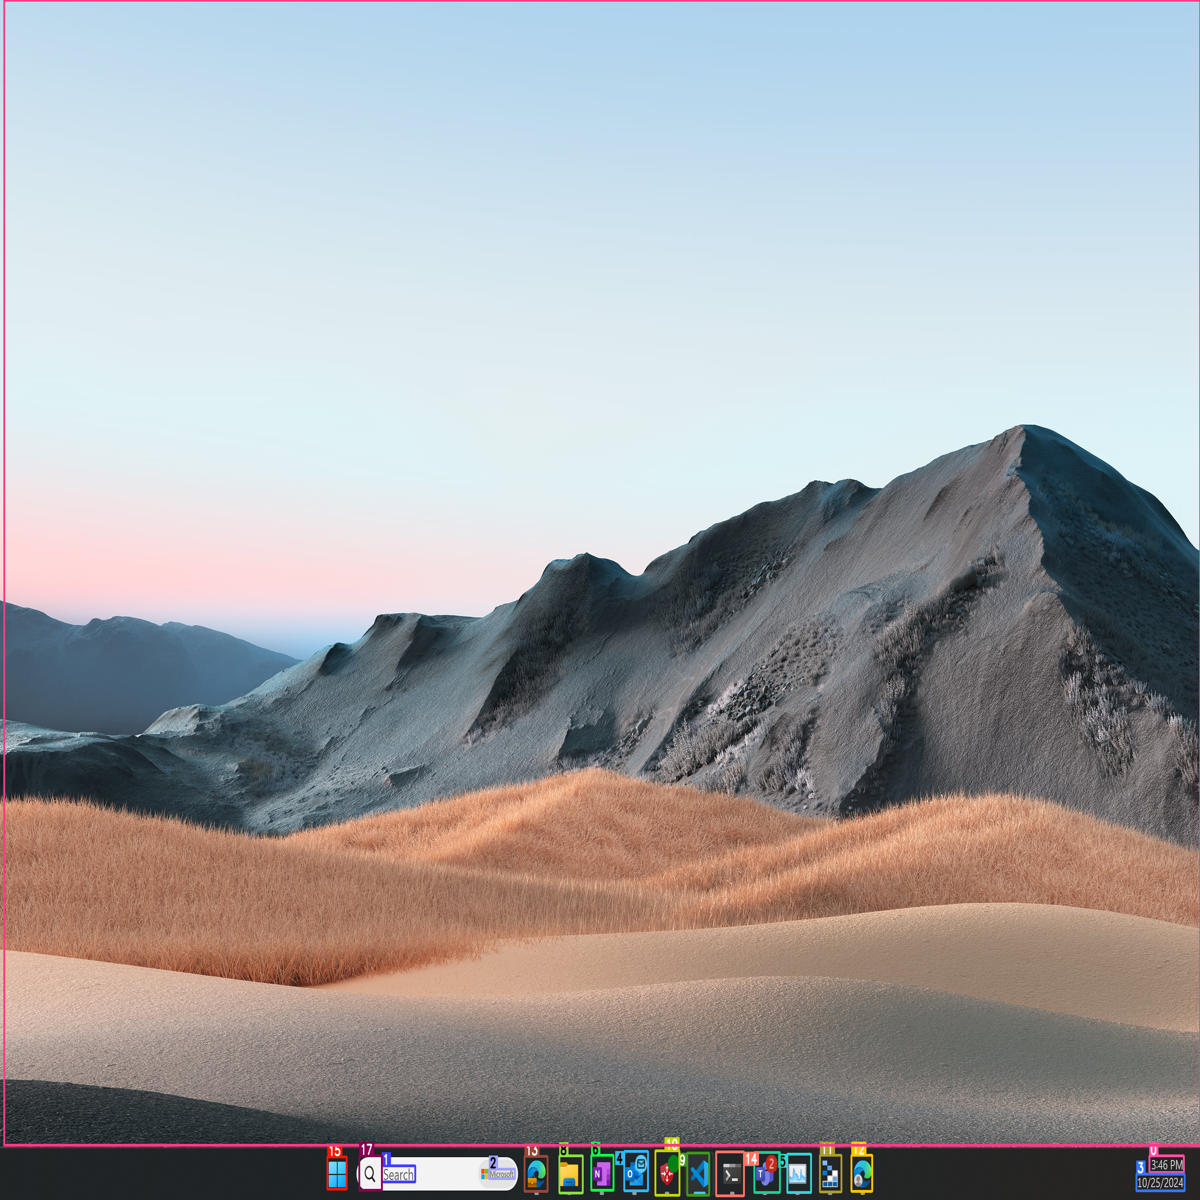

Text Box ID 0: 3.46 PM
Text Box ID 1: Search
Text Box ID 2: Microsoft
Text Box ID 3: 10/25/2024
Icon Box ID 4: Microsoft Outlook.
Icon Box ID 5: Image
Icon Box ID 6: Microsoft OneNote.
Icon Box ID 7: Microsoft Office.
Icon Box ID 8: a folder for organizing files.
Icon Box ID 9: Microsoft Office.
Icon Box ID 10: Security shield.
Icon Box ID 11: Microsoft 365.
Icon Box ID 12: Microsoft Edge browser.
Icon Box ID 13: Microsoft Edge browser.
Icon Box ID 14: Decrease
Icon Box ID 15: the Windows operating system.
Icon Box ID 16: mountains and a beach.
Icon Box ID 17: a search function.


In [19]:
display(procesed_image.resize((1200, 1200)))
print(icon_descriptions)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo


def process_image_gradio(image, box_threshold, iou_threshold, imgsz):
    image_result, _, parsed_text = process_image(
        image,
        ov_icon_detector,
        {"model": ov_icon_caption_gen, "processor": processor},
        reader,
        box_threshold=box_threshold,
        iou_threshold=iou_threshold,
        imgsz=imgsz,
    )
    return image_result, parsed_text


demo = make_demo(process_image_gradio)

try:
    demo.launch(debug=True, height=600)
except Exception:
    demo.launch(debug=True, share=True, height=600)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/